In [2]:
import pandas as pd
import mysql.connector as c
import os
import matplotlib.pyplot as plt
import seaborn as sns

# List of CSV files and their corresponding table names
csv_files = [('customers.csv', 'customers'),
             ('orders.csv', 'orders'),
             ('sellers.csv', 'sellers'),
             ('products.csv', 'products'),
             ('order_items.csv', 'order_items'),
             ('payments.csv', 'payments'),
             ('geolocation.csv','geolocation'),]  

# Connect to the MySQL database
conn = c.connect(host='localhost',
                 user='root',
                 password='shikha',
                 auth_plugin="mysql_native_password",
                 database='e_commerce')
cursor = conn.cursor()

# Folder containing the CSV files
folder_path =r"C:\Users\shiva\Downloads\archive"

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)

    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)

    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)

    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [4]:
import pandas as pd
import mysql.connector as c
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

conn = c.connect(host='localhost',
                 user='root',
                 password='shikha',
                 auth_plugin="mysql_native_password",
                 database='e_commerce')
cursor = conn.cursor()


# 1. List all unique cities where customers are located.

In [2]:
query='''select distinct customer_city from customers'''

cursor.execute(query)
data=cursor.fetchall()
df=pd.DataFrame(data,columns=["Cities"])
df

,Cities
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


# 2. Count the number of orders placed in 2017.

In [3]:
query='''select count(order_id) from orders where year(order_purchase_timestamp)=2017'''

cursor.execute(query)
data=cursor.fetchall()

"total orders placed in 2017",data[0][0]

('total orders placed in 2017', 90202)

# 3. Find the total sales per category.

In [4]:
query='''SELECT 
    UPPER(products.product_category) AS category,
    ROUND(SUM(payments.payment_value), 2) AS sales
FROM
    products
        JOIN
    order_items ON products.product_id = order_items.product_id
        JOIN
    payments ON payments.order_id = order_items.order_id
GROUP BY category;'''

cursor.execute(query)
data=cursor.fetchall()

df=pd.DataFrame(data,columns=["Category","Sales"])
df

,Category,Sales
0,PERFUMERY,4053909.28
1,FURNITURE DECORATION,11441411.13
2,TELEPHONY,3895056.41
3,BED TABLE BATH,13700429.37
4,AUTOMOTIVE,6818354.65
...,...,...
69,CDS MUSIC DVDS,9595.44
70,LA CUISINE,23308.24
71,FASHION CHILDREN'S CLOTHING,6285.36
72,PC GAMER,17395.44


# 4. Calculate the percentage of orders that were paid in installments.

In [5]:
query='''SELECT 
    (SUM(CASE
        WHEN payment_installments >= 1 THEN 1
        ELSE 0
    END)) / COUNT(*) * 100 AS percentage_of_orders_in_installments
FROM
    payments;'''

cursor.execute(query)
data=cursor.fetchall()
data[0][0]

Decimal('99.9981')

# 5.Count the number of customers from each state.

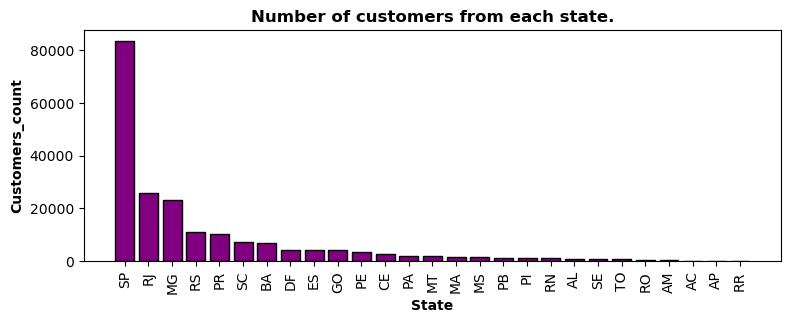

In [9]:
query='''select customer_state ,count(customer_id) from customers group by customer_state;'''

cursor.execute(query)
data=cursor.fetchall()
df=pd.DataFrame(data,columns=["State","Customers_count"])

df=df.sort_values(by="Customers_count",ascending=False)

plt.figure(figsize=(9,3))
plt.bar(df["State"],df["Customers_count"],color="purple",edgecolor="black")
plt.xticks(rotation=90)
plt.title("Number of customers from each state.",fontweight="bold")
plt.xlabel("State",fontweight="bold")
plt.ylabel("Customers_count",fontweight="bold")
plt.show()


# 6. Calculate the number of orders per month in 2018

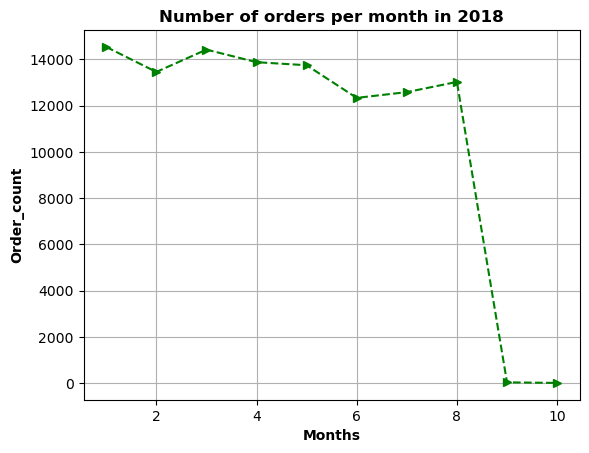

In [7]:
query='''SELECT 
    MONTH(order_purchase_timestamp) AS months_of_2018,
    COUNT(order_id) AS order_count
FROM
    orders
WHERE
    YEAR(order_purchase_timestamp) = 2018
GROUP BY MONTH(order_purchase_timestamp)
ORDER BY MONTH(order_purchase_timestamp);'''

cursor.execute(query)
data=cursor.fetchall()

df=pd.DataFrame(data,columns=["months_of_2018","order_count"])

plt.plot(df["months_of_2018"],df["order_count"],linestyle="--",color="green",marker=">")
plt.title("Number of orders per month in 2018",fontweight="bold")
plt.xlabel("Months",fontweight="bold")
plt.ylabel("Order_count",fontweight="bold")
plt.grid(True)
plt.show()

# 7. Find the average number of products per order,grouped by customer city.

In [8]:
query='''with cte as (SELECT 
   orders.order_id,orders.customer_id,
    COUNT(order_items.order_id) as order_count
FROM
    orders
        JOIN
    order_items ON orders.order_id = order_items.order_id
GROUP BY orders.order_id , orders.customer_id)
SELECT 
    customers.customer_city,
    ROUND(AVG(cte.order_count), 2) AS avg_orders
FROM
    customers
        JOIN
    cte ON customers.customer_id = cte.customer_id
GROUP BY customers.customer_city;
 '''

cursor.execute(query)
data=cursor.fetchall()
df=pd.DataFrame(data,columns=["Customers_city","Avg_orders"])
df


,Customers_city,Avg_orders
0,sao paulo,4.62
1,sao jose dos campos,4.55
2,porto alegre,4.70
3,indaial,4.46
4,treze tilias,5.09
...,...,...
4105,sambaiba,4.00
4106,guairaca,8.00
4107,japaratuba,4.00
4108,tuiuti,4.00


# 8. Calculate the percentage of total revenue contributed by each product category.

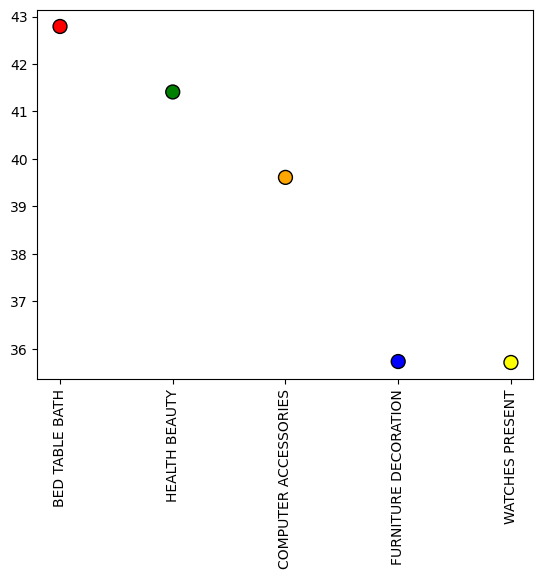

In [14]:
query='''SELECT 
    UPPER(products.product_category) AS category,
   round((SUM(payments.payment_value)/(select sum(payment_value) from payments))*100,2) AS sales
FROM
    products
        JOIN
    order_items ON products.product_id = order_items.product_id
        JOIN
    payments ON payments.order_id = order_items.order_id
GROUP BY category order by sales desc;'''

cursor.execute(query)
data=cursor.fetchall()

df=pd.DataFrame(data,columns=["Category","percentage_of_total_revenue"])

df=df.head()
c=["red","green","orange","blue","yellow"]
df=plt.scatter(df["Category"],df["percentage_of_total_revenue"],color=c,s=100,edgecolor="black")
plt.xticks(rotation=90)
plt.show()

# 9. Identify the correlation between product price and the number of times a product has been purchased.

In [10]:
query='''SELECT 
    products.product_category,
    order_items.price,
    COUNT(order_items.product_id) AS times_of_purchased
FROM
    products
        JOIN
    order_items ON products.product_id = order_items.product_id
GROUP BY products.product_category , order_items.price
ORDER BY times_of_purchased DESC;
'''

cursor.execute(query)
data=cursor.fetchall()

df=pd.DataFrame(data,columns=["Product_Category","price","times_of_purchased"])
a1=df["times_of_purchased"]
a2=df["price"]
b=np.corrcoef([a1,a2])
print(" The correlation between product price and the number of times a product has been purchased is",b[0][1])

 The correlation between product price and the number of times a product has been purchased is -0.07986190338879852


The correlation is approximately -0.0799 shows a very weak negative relationship , suggesting that price slightly increases,purchases might slightly decrease.

# 10. Calculated the total revenue generated by each seller, and rank them by revenue.

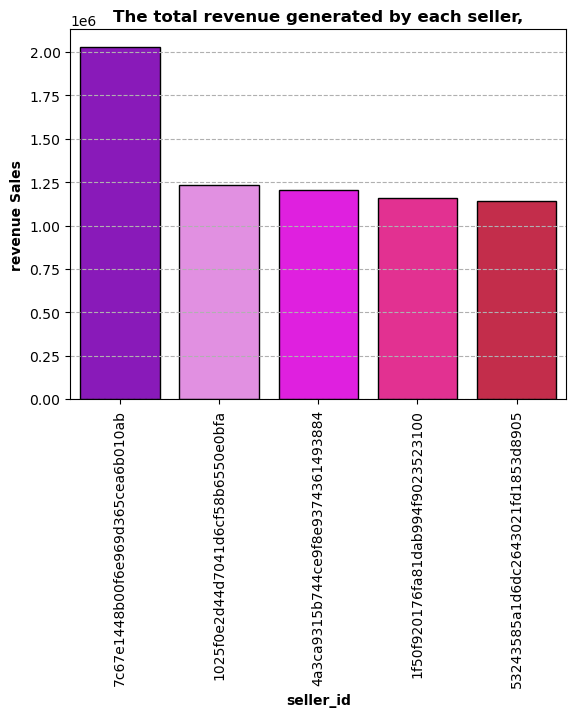

In [12]:
query='''SELECT *, dense_rank() over(order by revenue desc) as rn from (SELECT 
    order_items.seller_id, SUM(payments.payment_value) revenue
FROM
    order_items
        JOIN
    payments ON order_items.order_id = payments.order_id
GROUP BY order_items.seller_id)as a;'''

cursor.execute(query)
data=cursor.fetchall()

df=pd.DataFrame(data,columns=["seller_id","revenue","rank"])
df=df.head()
c=["darkviolet","violet","fuchsia","deeppink","crimson"]
sns.barplot(x="seller_id",y="revenue",data=df,palette=c,edgecolor="black")
plt.title("The total revenue generated by each seller,",fontweight="bold")
plt.xlabel("seller_id",fontweight="bold")
plt.ylabel("revenue Sales",fontweight="bold")
plt.grid(axis='y',linestyle="--")
plt.xticks(rotation=90)
plt.show()

# Conclusion:

In 2017, 90,202 orders were placed, with 99.99% in installments. Bed Table Bath and Furniture Decoration led revenue, and Sao Paulo (SP) had the most customers. The 1st and 3rd months of 2018 saw the highest orders. The top seller earned ₹2,028,668, and price changes had little effect on demand.